## import

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import time 

## Define some funtions

In [2]:
def f(txt,mapping):
    return [mapping[key] for key in txt] 
soft = torch.nn.Softmax(dim=1)

## Exam4: AbAcAd

### data

In [3]:
txt = list('AbAcAd')*100
txt[:10]

['A', 'b', 'A', 'c', 'A', 'd', 'A', 'b', 'A', 'c']

In [4]:
txt_x = txt[:-1]
txt_y = txt[1:]

In [5]:
txt_x[:5],txt_y[:5]

(['A', 'b', 'A', 'c', 'A'], ['b', 'A', 'c', 'A', 'd'])

In [6]:
x = torch.nn.functional.one_hot(torch.tensor([{'A':0,'b':1,'c':2,'d':3}[key] for key in txt_x])).float()
y = torch.nn.functional.one_hot(torch.tensor([{'A':0,'b':1,'c':2,'d':3}[key] for key in txt_y])).float()

In [7]:
x,y

(tensor([[1., 0., 0., 0.],
         [0., 1., 0., 0.],
         [1., 0., 0., 0.],
         ...,
         [1., 0., 0., 0.],
         [0., 0., 1., 0.],
         [1., 0., 0., 0.]]),
 tensor([[0., 1., 0., 0.],
         [1., 0., 0., 0.],
         [0., 0., 1., 0.],
         ...,
         [0., 0., 1., 0.],
         [1., 0., 0., 0.],
         [0., 0., 0., 1.]]))

### 실패했던 풀이: 구현1

In [8]:
class HNet(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.i2h = torch.nn.Linear(4,2)
        self.tanh = torch.nn.Tanh()
    def forward(self,x):
        hidden = self.tanh(self.i2h(x)) 
        return hidden 

In [9]:
torch.manual_seed(43052)
hnet = HNet()
linr = torch.nn.Linear(2,4) 
loss_fn = torch.nn.CrossEntropyLoss()
optimizr = torch.optim.Adam(list(hnet.parameters())+list(linr.parameters()))

In [10]:
for epoc in range(1): ## 20번만.. 
    ## 1
    ## 2
    hidden = hnet(x) 
    output = linr(hidden)
    loss = loss_fn(output,y) 
    ## 3 
    loss.backward()
    ## 4 
    optimizr.step()
    optimizr.zero_grad()

In [11]:
linr(hnet(x))

tensor([[-0.4160,  0.8445, -0.2058, -0.0542],
        [-0.3381,  0.8574, -0.2034,  0.0026],
        [-0.4160,  0.8445, -0.2058, -0.0542],
        ...,
        [-0.4160,  0.8445, -0.2058, -0.0542],
        [-0.1683,  0.6776, -0.0901,  0.1631],
        [-0.4160,  0.8445, -0.2058, -0.0542]], grad_fn=<AddmmBackward0>)

### 실패했던 풀이: 구현2

In [12]:
# class HNet(torch.nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.i2h = torch.nn.Linear(4,2)
#         self.tanh = torch.nn.Tanh()
#     def forward(self,x):
#         hidden = self.tanh(self.i2h(x)) 
#         return hidden 

In [13]:
torch.manual_seed(43052)
hnet = HNet()
linr = torch.nn.Linear(2,4) 
loss_fn = torch.nn.CrossEntropyLoss()
optimizr = torch.optim.Adam(list(hnet.parameters())+list(linr.parameters()))

In [14]:
T = len(x)
for epoc in range(1):
    ## 1~2
    loss = 0 
    for t in range(T):
        xt, yt = x[[t]], y[[t]]
        ht = hnet(xt)
        ot = linr(ht) 
        loss = loss + loss_fn(ot,yt)
    loss = loss/T 
    ## 3 
    loss.backward()
    ## 4 
    optimizr.step()
    optimizr.zero_grad()

In [15]:
linr(hnet(x))

tensor([[-0.4160,  0.8445, -0.2058, -0.0542],
        [-0.3381,  0.8574, -0.2034,  0.0026],
        [-0.4160,  0.8445, -0.2058, -0.0542],
        ...,
        [-0.4160,  0.8445, -0.2058, -0.0542],
        [-0.1683,  0.6776, -0.0901,  0.1631],
        [-0.4160,  0.8445, -0.2058, -0.0542]], grad_fn=<AddmmBackward0>)

### 순환신경망의 아이디어

#### ***모티브***

***(예비생각1) ${\boldsymbol h}$에 대한 이해***

${\boldsymbol h}$는 사실 문자열 'abcd'들을 숫자로 바꾼 또 다른 형식의 숫자표현이라 해석할 수 있음. 즉 원핫인코딩과 다른 또 다른 형태의 숫자표현이라 해석할 수 있다. (사실 원핫인코딩보다 약간 더 (1) 액기스만 남아서 (2) 숙성된 느낌을 준다) 
- (why1) h는 "학습을 용이하게 하기 위해서 x를 적당히 선형적으로 전처리한 상태"라고 이해가능
- (why2) 실제로 예시를 살펴보면 그러했다. 

결론: 사실 ${\boldsymbol h}$는 잘 숙성되어있는 입력정보 ${\bf X}$ 그 자체로 해석 할 수 있다. 

***(예비생각2) [수백년전통을 이어가는 방법](https://www.joongang.co.kr/article/24087690#home)***

```
“1리터에 500만원에 낙찰된 적 있습니다.”
“2kg에 1억원 정도 추산됩니다.”
“20여 종 종자장을 블렌딩해 100ml에 5000만원씩 분양 예정입니다.”

모두 씨간장(종자장) 가격에 관한 실제 일화다.

(중략...)

위스키나 와인처럼 블렌딩을 하기도 한다. 
새로 담근 간장에 씨간장을 넣거나, 씨간장독에 햇간장을 넣어 맛을 유지하기도 한다. 
이를 겹장(또는 덧장)이라 한다. 
몇몇 종갓집에선 씨간장 잇기를 몇백 년째 해오고 있다. 
매년 새로 간장을 담가야 이어갈 수 있으니 불씨 꺼트리지 않는 것처럼 굉장히 어려운 일이다.
이렇게 하는 이유는 집집마다 내려오는 고유 장맛을 잃지 않기 위함이다. 
씨간장이란 그만큼 소중한 주방의 자산이며 정체성이다.
```

덧장: 새로운간장을 만들때, 옛날간장을 섞어서 만듬 

`*` 기존방식
- $\text{콩물} \overset{\text{숙성}}{\longrightarrow} \text{간장}$

`*` 수백년 전통의 간장맛을 유지하는 방식

- $\text{콩물}_0 \overset{\text{숙성}}{\longrightarrow} \text{간장}_0$
- $\text{콩물}_1, \text{간장}_0 \overset{\text{숙성}}{\longrightarrow} \text{간장}_1$
- $\text{콩물}_2, \text{간장}_1 \overset{\text{숙성}}{\longrightarrow} \text{간장}_2$

`*` 수백년 전통의 간장맛을 유지하면서 조리를 한다면? 

- $\text{콩물}_0 \overset{\text{숙성}}{\longrightarrow} \text{간장}_0 \overset{\text{조리}}{\longrightarrow} \text{간장계란밥}_0$
- $\text{콩물}_1, \text{간장}_0 \overset{\text{숙성}}{\longrightarrow} \text{간장}_1 \overset{\text{조리}}{\longrightarrow} \text{간장계란밥}_1$
- $\text{콩물}_2, \text{간장}_1 \overset{\text{숙성}}{\longrightarrow} \text{간장}_2 \overset{\text{조리}}{\longrightarrow} \text{간장계란밥}_2$

점점 맛있는 간장계란밥이 탄생함 

***아이디어***

`*` 수백년 전통의 간장맛을 유지하면서 조리하는 과정을 수식으로? 

- $\boldsymbol{x}_0 \overset{\text{숙성}}{\longrightarrow} \boldsymbol{h}_0 \overset{\text{조리}}{\longrightarrow} \hat{\boldsymbol y}_0$
- $\boldsymbol{x}_1, \boldsymbol{h}_0 \overset{\text{숙성}}{\longrightarrow} \boldsymbol{h}_1 \overset{\text{조리}}{\longrightarrow} \hat{\boldsymbol y}_1$
- $\boldsymbol{x}_2, \boldsymbol{h}_1 \overset{\text{숙성}}{\longrightarrow} \boldsymbol{h}_2 \overset{\text{조리}}{\longrightarrow} \hat{\boldsymbol y}_2$

이제 우리가 배울것은 (1) "$\text{콩물}_{t}$"와 "$\text{간장}_{t-1}$"로 "$\text{간장}_t$"를 `숙성`하는 방법 (2) "$\text{간장}_t$"로 "$\text{간장계란밥}_t$를 `조리`하는 방법이다 

즉 `숙성`담당 네트워크와 `조리`담당 네트워크를 각각 만들어 학습하면 된다. 

***(예비학습3)*** 두개의 네트워크를 학습하는 방법

#### ***기존구조***

#### ***바뀌는 구조***

(1) $t=0$

${\boldsymbol h}_0=[[0,0]]$ 

---

(2) $t=1$ 

${\boldsymbol h}_1= \tanh({\boldsymbol x}_1{\bf W}_{ih}+{\boldsymbol h}_0{\bf W}_{hh}+{\boldsymbol b}_{ih}+{\boldsymbol b}_{hh})$
- ${\boldsymbol x}_1$: (1,4) 
- ${\bf W}_{ih}$: (4,2) 
- ${\boldsymbol h}_0$: (1,2) 
- ${\bf W}_{hh}$: (2,2) 
- ${\boldsymbol b}_{ih}$: (1,2)
- ${\boldsymbol b}_{hh}$: (1,2)

${\boldsymbol o}_1= {\bf W}_{ho}{\boldsymbol h}_1+{\boldsymbol b}_{ho}$

$\hat{\boldsymbol y}_1 = \text{soft}({\boldsymbol o}_1)$

---

일반화된 알고리즘 

***(ver1)***

init $\boldsymbol{h}_0$ 

for $t$ in $1:T$ 

- ${\boldsymbol h}_t= \tanh({\boldsymbol x}_t{\bf W}_{ih}+{\boldsymbol h}_{t-1}{\bf W}_{hh}+{\boldsymbol b}_{ih}+{\boldsymbol b}_{hh})$
- ${\boldsymbol o}_t= {\bf W}_{ho}{\boldsymbol h}_1+{\boldsymbol b}_{ho}$
- $\hat{\boldsymbol y}_t = \text{soft}({\boldsymbol o}_1)$
    

***(ver2)***

```Python 
init hidden

for t in 1:T 
    hidden = tanh(linr(x)+linr(hidden))
    output = linr(hidden)
    yt_hat = soft(output)
```    

- 코드상으로는 $h_t$와 $h_{t-1}$의 구분이 교모하게 사라진다. (그래서 오히려 좋아)

***(ㄴㅇㄹ)***

```Python 
### 
class rNNCell(torch.nn.Module):
    def __init__(self):
        super().__init__()
        linr1 = torch.nn.Linear(?,?) 
        linr2 = torch.nn.Linear(?,?) 
        tanh = torch.nn.Tanh()
    def forward(self,hidden,x):
        hidden = tanh(lrnr1(x)+lrnr2(hidden))
        return hidden

init ht
rnncell = rNNCell()

for t in 1:T 
    xt, yt = x[[t]], y[[t]] 
    ht = rnncell(xt, ht)
    ot = linr(ht) 
    loss = loss + loss_fn(ot, yt)

```    

### 순환신경망 구현1 -- 성공 

`(1)` 숙성담당 네트워크

In [16]:
#
# 전통을 보존하지 않고 간장을 만드는 방식 
# class HNet(torch.nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.i2h = torch.nn.Linear(4,2)
#         self.tanh = torch.nn.Tanh()
#     def forward(self,x):
#         hidden = self.tanh(self.i2h(x)) 
#         return hidden 

class rNNCell(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.i2h = torch.nn.Linear(4,2) ## 콩물1 -> linr(콩물1)
        self.h2h = torch.nn.Linear(2,2) ## 간장0 -> linr(간장0)
        self.tanh = torch.nn.Tanh()
    def forward(self,x,hidden):
        hidden = self.tanh(self.i2h(x)+self.h2h(hidden)) ## linr(콩물1) + linr(간장0)---tanh---> 간장1  // **이게 비법 
        return hidden

In [17]:
torch.manual_seed(43052)
rnncell = rNNCell() # 숙성담당

`(2)` 조리담당 네트워크

In [18]:
torch.manual_seed(43052)
cook = torch.nn.Linear(2,4) # 조리담당

`(3)` 손실함수, 옵티마이저 설계 

In [19]:
loss_fn = torch.nn.CrossEntropyLoss() 
optimizr = torch.optim.Adam(list(rnncell.parameters())+list(cook.parameters())) # 우리가 배울것: 숙성하는 방법 + 요리하는 방법 

- ${\bf W}_{ih}, {\bf W}_{hh}, {\boldsymbol b}_{ih}, {\boldsymbol b}_{hh}$

`(4)` 학습 (6분정도 걸림)

In [20]:
T = len(x)
t1 = time.time()
for epoc in range(5000):
    ## 1~2
    loss = 0 
    ht = torch.zeros(1,2)
    for t in range(T):
        xt, yt = x[[t]], y[[t]]       
        ht = rnncell(xt,ht) # 
        ot = cook(ht)
        loss = loss + loss_fn(ot,yt) 
    loss = loss/T 
    ## 3 
    loss.backward()
    ## 4 
    optimizr.step()
    optimizr.zero_grad()
t2 = time.time() 
t2-t1

313.3899025917053

`(5)` 시각화 

In [21]:
T = len(x) 
hidden = torch.zeros(T,2) # 599년치 h를 담을 변수 
_water = torch.zeros(1,2) # 맹물 
hidden[[0]] = rnncell(x[[0]],_water) 
for t in range(1,T):
    hidden[[t]] = rnncell(x[[t]],hidden[[t-1]])

In [22]:
yhat = soft(cook(hidden))
yhat 

tensor([[1.6522e-02, 6.2036e-01, 1.0433e-01, 2.5879e-01],
        [9.9965e-01, 6.5788e-05, 1.8450e-05, 2.6785e-04],
        [7.6673e-05, 1.9704e-01, 8.0201e-01, 8.7218e-04],
        ...,
        [7.4634e-05, 1.9501e-01, 8.0407e-01, 8.4751e-04],
        [9.4785e-01, 7.4712e-03, 6.1181e-04, 4.4064e-02],
        [3.6306e-02, 1.2466e-01, 2.8862e-03, 8.3615e-01]],
       grad_fn=<SoftmaxBackward0>)

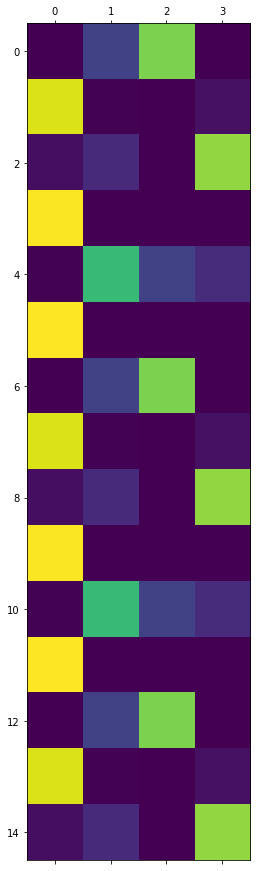

In [23]:
plt.matshow(yhat.data[-15:])

- 아주 특이한 특징: yhat[:15], yhat[:-15] 의 적합결과가 다르다
- 왜? 간장계란밥은 간장이 중요한데, 간장은 시간이 갈수록 맛있어지니까..

### 순환신경망 구현2 (with RNNCell) -- 성공 

ref: https://pytorch.org/docs/stable/generated/torch.nn.RNNCell.html

`(1)` 숙성네트워크

선언

In [24]:
rnncell = torch.nn.RNNCell(4,2)

가중치초기화

In [25]:
torch.manual_seed(43052)
_rnncell = rNNCell() # 숙성담당

In [26]:
rnncell.weight_ih.data = _rnncell.i2h.weight.data
rnncell.bias_ih.data = _rnncell.i2h.bias.data
rnncell.weight_hh.data = _rnncell.h2h.weight.data
rnncell.bias_hh.data = _rnncell.h2h.bias.data

`(2)` 조리네트워크

In [27]:
torch.manual_seed(43052)
cook = torch.nn.Linear(2,4) # 조리담당

`(3)` 손실함수와 옵티마이저 

In [28]:
loss_fn = torch.nn.CrossEntropyLoss() 
optimizr = torch.optim.Adam(list(rnncell.parameters())+list(cook.parameters())) # 우리가 배울것: 숙성하는 방법 + 요리하는 방법 

`(4)` 학습

In [29]:
T = len(x)
t1 = time.time()
for epoc in range(5000):
    ## 1~2
    loss = 0 
    ht = torch.zeros(1,2)
    for t in range(T):
        xt, yt = x[[t]], y[[t]]       
        ht = rnncell(xt,ht) 
        ot = cook(ht)
        loss = loss + loss_fn(ot,yt) 
    loss = loss/T 
    ## 3 
    loss.backward()
    ## 4 
    optimizr.step()
    optimizr.zero_grad()
t2 = time.time() 
t2-t1

314.6121292114258

`(5)` 시각화 

In [30]:
T = len(x) 
hidden = torch.zeros(T,2) # 599년치 h를 담을 변수 
_water = torch.zeros(1,2) # 맹물 
hidden[[0]] = rnncell(x[[0]],_water) 
for t in range(1,T):
    hidden[[t]] = rnncell(x[[t]],hidden[[t-1]])

In [31]:
yhat = soft(cook(hidden))
yhat 

tensor([[1.6522e-02, 6.2036e-01, 1.0433e-01, 2.5879e-01],
        [9.9965e-01, 6.5788e-05, 1.8450e-05, 2.6785e-04],
        [7.6673e-05, 1.9704e-01, 8.0201e-01, 8.7218e-04],
        ...,
        [7.4634e-05, 1.9501e-01, 8.0407e-01, 8.4751e-04],
        [9.4785e-01, 7.4712e-03, 6.1181e-04, 4.4064e-02],
        [3.6306e-02, 1.2466e-01, 2.8862e-03, 8.3615e-01]],
       grad_fn=<SoftmaxBackward0>)

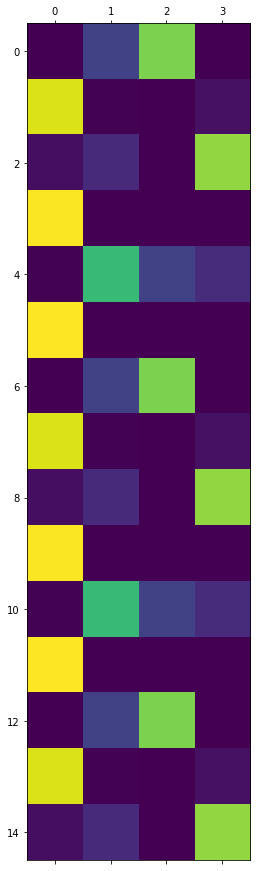

In [32]:
plt.matshow(yhat.data[-15:])

### 순환신경망 구현3 (with RNN) -- 성공 

---

(예비학습)

`-` 아무리 생각해도 yhat구하려면 좀 귀찮음

In [33]:
T = len(x) 
hidden = torch.zeros(T,2) # 599년치 h를 담을 변수 
_water = torch.zeros(1,2) # 맹물 
hidden[[0]] = rnncell(x[[0]],_water) 
for t in range(1,T):
    hidden[[t]] = rnncell(x[[t]],hidden[[t-1]])

In [34]:
soft(cook(hidden))

tensor([[1.6522e-02, 6.2036e-01, 1.0433e-01, 2.5879e-01],
        [9.9965e-01, 6.5788e-05, 1.8450e-05, 2.6785e-04],
        [7.6673e-05, 1.9704e-01, 8.0201e-01, 8.7218e-04],
        ...,
        [7.4634e-05, 1.9501e-01, 8.0407e-01, 8.4751e-04],
        [9.4785e-01, 7.4712e-03, 6.1181e-04, 4.4064e-02],
        [3.6306e-02, 1.2466e-01, 2.8862e-03, 8.3615e-01]],
       grad_fn=<SoftmaxBackward0>)

`-` 이렇게 하면 쉽게(?) 구할 수 있음 

In [35]:
rnn = torch.nn.RNN(4,2) 

In [36]:
rnn.weight_hh_l0.data = rnncell.weight_hh.data 
rnn.bias_hh_l0.data = rnncell.bias_hh.data 
rnn.weight_ih_l0.data = rnncell.weight_ih.data 
rnn.bias_ih_l0.data = rnncell.bias_ih.data 

In [37]:
_water

tensor([[0., 0.]])

In [38]:
soft(cook(rnn(x,_water)[0]))

tensor([[1.6522e-02, 6.2036e-01, 1.0433e-01, 2.5879e-01],
        [9.9965e-01, 6.5788e-05, 1.8450e-05, 2.6785e-04],
        [7.6673e-05, 1.9704e-01, 8.0201e-01, 8.7218e-04],
        ...,
        [7.4634e-05, 1.9501e-01, 8.0407e-01, 8.4751e-04],
        [9.4785e-01, 7.4712e-03, 6.1181e-04, 4.4064e-02],
        [3.6306e-02, 1.2466e-01, 2.8862e-03, 8.3615e-01]],
       grad_fn=<SoftmaxBackward0>)

- 똑같음!

`-` rnn(x,_water)의 결과는 (1) 599년치 간장 (2) 599번째 간장 이다 

In [39]:
rnn(x,_water)

(tensor([[-0.2232,  0.9769],
         [-0.9999, -0.9742],
         [ 0.9154,  0.9992],
         ...,
         [ 0.9200,  0.9992],
         [-0.9978, -0.0823],
         [-0.9154,  0.9965]], grad_fn=<SqueezeBackward1>),
 tensor([[-0.9154,  0.9965]], grad_fn=<SqueezeBackward1>))

***(예비학습결론) torch.nn.RNN(4,2)는 torch.nn.RNNCell(4,2)의 batch 버전이다. (for문이 포함된 버전이다)***

---

torch.nn.RNN(4,2)를 이용하여 구현하자. 

`(1)` 숙성네트워크

선언

In [40]:
rnn = torch.nn.RNN(4,2)

가중치초기화

In [41]:
torch.manual_seed(43052)
_rnncell = rNNCell() 

In [42]:
rnn.weight_ih_l0.data = _rnncell.i2h.weight.data
rnn.bias_ih_l0.data = _rnncell.i2h.bias.data
rnn.weight_hh_l0.data = _rnncell.h2h.weight.data
rnn.bias_hh_l0.data = _rnncell.h2h.bias.data

`(2)` 조리네트워크

In [43]:
torch.manual_seed(43052)
cook = torch.nn.Linear(2,4)

`(3)` 손실함수와 옵티마이저

In [44]:
loss_fn = torch.nn.CrossEntropyLoss() 
optimizr = torch.optim.Adam(list(rnn.parameters())+list(cook.parameters())) # 우리가 배울것: 숙성하는 방법 + 요리하는 방법 

`(4)` 학습

In [45]:
t1 = time.time()
for epoc in range(5000):
    ## 1
    _water = torch.zeros(1,2)
    hidden, _ = rnn(x,_water)
    output = cook(hidden)
    ## 2 
    loss = loss_fn(output,y) 
    ## 3 
    loss.backward()
    ## 4 
    optimizr.step()
    optimizr.zero_grad()
t2 = time.time() 
t2-t1

63.54761457443237

`(5)` 시각화

In [46]:
yhat = soft(cook(rnn(x,_water)[0]))
yhat

tensor([[1.6522e-02, 6.2036e-01, 1.0433e-01, 2.5879e-01],
        [9.9965e-01, 6.5788e-05, 1.8450e-05, 2.6785e-04],
        [7.6673e-05, 1.9704e-01, 8.0201e-01, 8.7218e-04],
        ...,
        [7.4634e-05, 1.9501e-01, 8.0407e-01, 8.4751e-04],
        [9.4785e-01, 7.4711e-03, 6.1181e-04, 4.4064e-02],
        [3.6306e-02, 1.2466e-01, 2.8862e-03, 8.3615e-01]],
       grad_fn=<SoftmaxBackward0>)

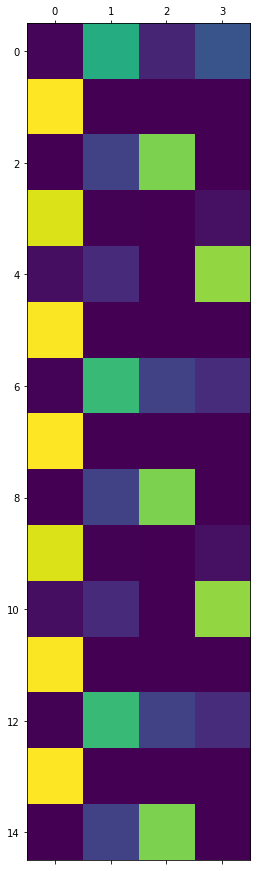

In [47]:
plt.matshow(yhat.data[:15])